# Minihack Crossing River
Team: Can do (M)AI \
Members: Andrea Piras, Chiara Cecchetti, Jacopo Raffi, Nicola Emmolo
Course: Artificial AI Fundamentals 2023/2024

## Overview of the project
The project Minihack Crossing River is based on the standard environment "River" of the MiniHack Environment Zoo (https://minihack.readthedocs.io/en/latest/envs/navigation/river.html).
The final goal of the agent in this task is to reach the stairs which are in the other side of the river. To cross the river the agent mush push one boulder into the it which becomes crossable and finally he can reach the stairs.

The goal of this project is to find a solution that is able to complete as much games as possibile in the most efficient way in time and in the number of steps done.

We will show two solutions, the first one is the classic A star algorithm. And the second, our custom solution which we call Online A star which is based on the classic A star algorithm enhanced with a knowledge based approach.

Finally, we show an empirical evaluation comparing this two solutions. 

## Imports required

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *

## Environment
First we create and visualize the environment using "Minihack-River-Narrow-V0", one of the standard environments of MiniHack Environment Zoo. The environment changes at each execution including the starting position of the agent, the boulder, the river and the visibility (black cells).

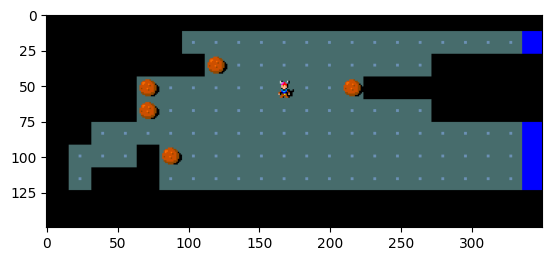

In [2]:
minihack.envs.river.MiniHackRiver.__init__ = new_init_  # Aggiornamento mappa river
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel", "colors"), seeds = [1,2,8])
state = env.reset()
plt.imshow(state['pixel'][100:250, 400:750]) #Immagine ristretta con range [y][x]
game_map = state['chars']
game = state['pixel']
color_map = state['colors']

## Agent, boulder, river
Now that the environment is created we find the coordinates of the the agent, boulders and river. Once we have obtained all the coordinates we select the boulder to push and the river cell in which the boulder has to be pushed.

In [3]:
start = get_player_location(game_map)
boulders = get_boulder_locations(game_map, [])
river_positions = find_river(env,game_map)
print("Agent starting position: ", start, "Boulders positions: ", boulders, "River positions: ", river_positions)

Agent starting position:  (9, 35) Boulders positions:  [(8, 32), (9, 29), (9, 38), (10, 29), (12, 30)] River positions:  [(7, 46), (11, 46), (12, 46), (13, 46)]


We select the most convenient boulder to push into the the river, once it is computed we find the river cell in which the boulder has to be dropped.

In [4]:
coordinates_min_boulder = get_best_global_distance(start, boulders, river_positions)
temp = get_min_distance_point_to_points(coordinates_min_boulder[0],coordinates_min_boulder[1], river_positions)
final_position = tuple(temp[0])
print("Boulder to push: ", coordinates_min_boulder, "River cell of destination: ", final_position)

Boulder to push:  (9, 38) River cell of destination:  (7, 46)


# Path
In this section we use the classic A star algorithm to compute the path first from the boulder to the river, then from the agent to the boulder pushing positions.
The boulder pushing position is the cell in which the agent has to be to push the boulder in the correct direction.

TODO: talk about chebyshev and a star in general

We compute in this order:
* The path that the boulder has to follow to reach the correct river cell
* The correct pushing position of the boulder
* The path that agent has to follow to reach the pushing position

In [5]:
path_boulder_river = a_star(game_map, coordinates_min_boulder,final_position, True, False, get_optimal_distance_point_to_point)
pushing_position = position_for_boulder_push(coordinates_min_boulder, path_boulder_river[1])[1]
path_player_to_pushing_position = a_star(game_map, start,  pushing_position,False,False, get_optimal_distance_point_to_point)


After we have computed the path that the boulder has to do to reach the river, we have to derive from it the path that the agent has to do in order to follow the boulder pushing it. Finally we obtain the full path that the agent has to do to reach the river.

In [6]:
try:
    _, path_player_to_river = push_boulder_path(path_boulder_river)
    path_player_to_river = path_player_to_river[1:] # Remove the first element because the agent is already in the pushing position
    agent_full_path = path_player_to_pushing_position + path_player_to_river
    agent_full_path.append(path_boulder_river[-1]) # Add the river position so the agent steps where there was the river
except Exception as e:
    print("An error occurred:", str(e))


## Actions
In this section we translate the path obtained in actual actions and we execute the steps. 
TODO: talk about reward

Rewards: 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Total reward:  0.0


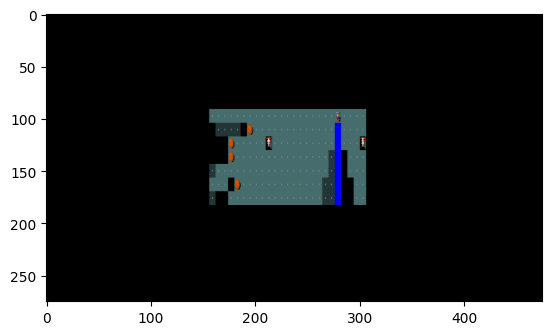

In [7]:
actions, names = actions_from_path(start, agent_full_path) 
player_pos = plot_animated_sequence(env,game, game_map,actions[1:]) #Remove first action because it is the start position